In [1]:
import pandas as pd
import numpy as np
import gensim 
import jieba
from gensim.models import Word2Vec 
import random 
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
import os 
import seaborn as sns 

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
os.chdir('F:\药物靶标相互作用\source codes\examples')
def read_data(filename):
    data=pd.read_csv(filename)
    return data

In [3]:
protein_data=read_data('proteindata.csv')
#drug_data=read_data('drugdata.csv')

In [4]:
protein_data.head()

,uniprot_id,proteinseq,properties_0,properties_1,properties_2,properties_3,word2vec_0,word2vec_1,word2vec_2,word2vec_3,...,word2vec_90,word2vec_91,word2vec_92,word2vec_93,word2vec_94,word2vec_95,word2vec_96,word2vec_97,word2vec_98,word2vec_99
0,P45059,MVKFNSSRKSGKSKKTIRKLTAPETVKQNKPQKVFEKCFMRGRYML...,0.259212,-0.187348,-0.008600,-0.068595,0.126723,0.039810,0.017970,-0.039037,...,0.011674,0.029054,-0.038777,-0.007002,-0.030550,0.033212,-0.046502,-0.129363,-0.028781,-0.026470
1,P19113,MMEPEEYRERGREMVDYICQYLSTVRERRVTPDVQPGYLRAQLPES...,0.689451,0.826772,-1.207201,-1.044135,0.123122,0.021581,0.024236,-0.026347,...,-0.002226,0.042825,-0.036616,-0.023725,-0.010333,0.037779,-0.041307,-0.145163,-0.030131,-0.022315
2,Q9UI32,MRSMKALQKALSRAGSHCGRGGWGHPSRSPLLGGGVRHHLSEAAAQ...,0.444997,-1.858471,-0.196940,-0.450369,0.092008,0.021910,0.025578,-0.009207,...,-0.007500,0.058358,-0.042225,-0.044831,-0.022757,0.053458,-0.021026,-0.159979,-0.049246,-0.013091
3,P00488,MSETSRTAFGGRRAVPPNNSNAAEDDLPTVELQGVVPRGVNLQEFL...,0.754638,-1.074416,-1.447616,-1.499073,0.125651,0.023590,0.030623,-0.006758,...,-0.013050,0.051362,-0.013993,-0.027719,-0.027706,0.031993,-0.024556,-0.142545,-0.007536,-0.015915
4,P35228,MACPWKFLFKTKFHQYAMNGEKDINNNVEKAPCATSSPVTQDDLQY...,1.794381,-0.345303,-0.616146,-1.004738,0.111152,0.015229,0.029945,0.004321,...,-0.004685,0.043472,-0.028695,-0.005041,-0.008263,0.030612,-0.024846,-0.147441,-0.015954,0.012910


In [5]:
def word2vec(dims,data,n,window_size,negative_size):
    texts = [[word for word in re.findall(r'.{3}',document)] for document in list(data)]
    model = Word2Vec(texts,size=dims,window=window_size,min_count=1,negative=negative_size,sg=1,sample=0.001,hs=1,workers=4)
    vectors = pd.DataFrame([model[word] for word in (model.wv.vocab)])
    vectors['Word'] = list(model.wv.vocab)
    word_vec = pd.DataFrame()
    dictionary=[]
    Index = []
    for i in range(len(data)):
        Index.append(i)
    Index = list(Index)
    # Word segmentation
    for i in range(len(texts)):
        i_word=[]         
        for w in range(len(texts[i])):
            i_word.append(Index[i])    
        dictionary.extend(i_word)

    word_vec['Id'] = dictionary

    # word vectors generation
    dictionary=[]
    for i in range(len(texts)):
        i_word=[]         
        for w in range(len(texts[i])):
            i_word.append(texts[i][w])    
        dictionary.extend(i_word)
    word_vec['Word'] = dictionary

    del dictionary,i_word
    word_vec = word_vec.merge(vectors,on='Word', how='left')
    word_vec.columns = ['Id']+['Word']+["vec_{0}".format(i) for i in range(0,dims)]

    return word_vec

In [6]:
def feature_embeddings(word_vec,dims):
    word_vec=word_vec.drop('Word',axis=1)
    name = ["vec_{0}".format(i) for i in range(0,dims)]
    feature_embeddings = pd.DataFrame(word_vec.groupby(['Id'])[name].agg('mean')).reset_index()
    feature_embeddings.columns=["Index"]+["mean_ci_{0}".format(i) for i in range(0,dims)]
    return feature_embeddings
protein_seq=protein_data['proteinseq']
prot_vec=word2vec(100,protein_seq,3,5,5)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


In [7]:
from sklearn.manifold import TSNE
n_components = 2
tsne=TSNE(n_components= n_components)
X = tsne.fit_transform(protein_data.iloc[:,6:])


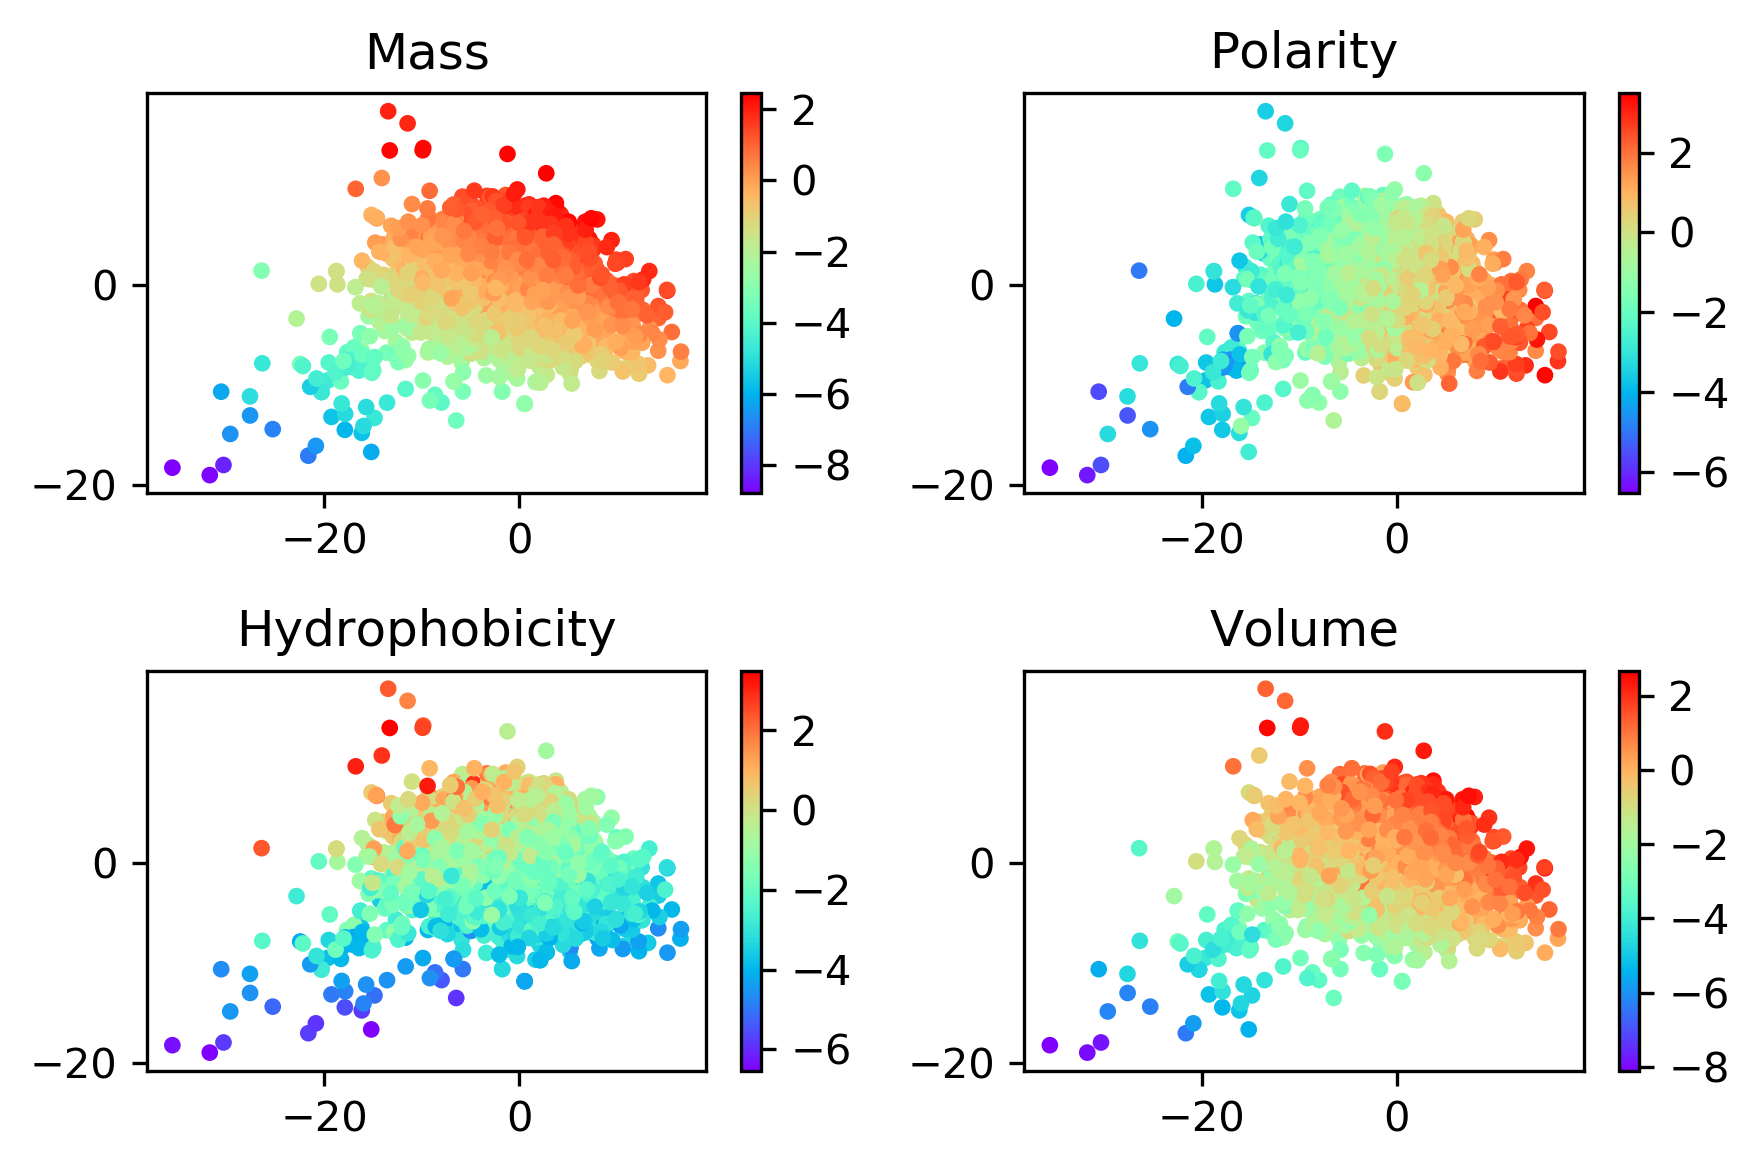

In [8]:
plt.rcParams['savefig.dpi'] = 300    #图片像素
plt.rcParams['figure.dpi'] = 300
fig,ax = plt.subplots(2,2)

color_1=protein_data.iloc[:,34]
figure_mass=ax[0][0].scatter(X[:,0],X[:,1],c =color_1 ,marker='.',cmap=plt.cm.rainbow)
ax[0][0].set_title('Mass',fontsize=12)
fig.colorbar(figure_mass,ax=ax[0][0])

color_2=protein_data.iloc[:,7]
figure_polarity=ax[0][1].scatter(X[:,0],X[:,1],c =color_2 ,marker='.',cmap=plt.cm.rainbow)
ax[0][1].set_title('Polarity',fontsize=12)
plt.colorbar(figure_polarity,ax=ax[0][1])

color_3=protein_data.iloc[:,88]
figure_Hydrophobicity=ax[1][0].scatter(X[:,0],X[:,1],c =color_3 ,marker='.',cmap=plt.cm.rainbow)
ax[1][0].set_title('Hydrophobicity',fontsize=12)
plt.colorbar(figure_polarity,ax=ax[1][0])

color_4=protein_data.iloc[:,23]
figure_volume=ax[1][1].scatter(X[:,0],X[:,1],c =color_4 ,marker='.',cmap=plt.cm.rainbow)
ax[1][1].set_title('Volume',fontsize=12)
plt.colorbar(figure_volume,ax=ax[1][1])

plt.tight_layout()
plt.savefig('protein_properties_distribution.jpg')